# 11 - Propensity Score

## The Psychology of Growth

긍정심리학은 어떤 행동이 위대한 삶으로 이어지는지 연구하는 통계학과 자기계발서의 교차점에 해당하는 분야입니다. 긍정심리학의 유명한 발견 중 하나는 **성장 마인드**입니다. 사람들은 고정 사고방식이나 성장 사고방식을 가집니다. 고정 사고방식은 태어날 때나 어린 시절에 능력이 결정된다고 생각하는 사고방식입니다. 능력은 이미 고정되어 있으며 평생 변하지 않습니다. 즉, 가지고 있지 않은 능력은 얻을 수 없습니다. 고정 사고방식을 가진 사람은 못하는 일에 시간을 낭비하지 않습니다. 일을 해결하는 방법을 배울 수 없기 때문입니다. 반면, 성장 사고방식을 가진 사람은 학습을 통해 능력을 얻을 수 있다고 믿습니다. 이 사람들에게 실패는 학습 과정의 일부입니다.

여기서는 어떤 사고방식이 더 나은지 논의하지 않겠습니다. (아마 중간쯤일 겁니다.) 우리의 주제와는 조금 벗어나 있습니다. 중요한 사실은 심리학자들이 성장 사고방식을 가진 사람들이 더 나은 삶을 사는 경향을 발견했다는 것입니다. 성장 사고방식은 목적을 달성할 가능성이 더 높습니다.

인과추론을 학습하면서 이러한 주장을 비판적으로 보는 시각을 배웠습니다. 성장 사고방식이 더 많은 것을 이루게 할까요? 아니면 단순히 많은 것을 성취한 사람들이 성장 사고방식에 관심이 있을까요? 닭과 달걀 중 무엇이 먼저일까요? `potential outcome` 표기로 주장에 편향이 있음을 보일 수 있습니다. $Y_0|T=1$(성장 사고방식)은 $Y_0|T=0$(고정 사고방식)보다 클 것입니다. 즉, 성장 사고방식을 가진 사람들은 고정 사고방식을 가졌더라도 더 많은 것을 달성할 가능성이 높습니다.

심리학자들은 이 문제를 연구하기 위해 [The National Study of Learning Mindsets](https://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/#)를 설계했습니다. 미국 공립 고등학교를 대상으로 무작위 연구를 수행했습니다. 무작위 학생은 성장 사고방식에 관한 세미나를 받았으며 학업적 성취를 측정하기 위해 대학 생활을 추적했습니다. 측정값은 성취도로 집계되어 표준화되었습니다. 사생활 보호를 위해 실제 데이터는 공개하지 않습니다. 대신 통계적으로 같은 시뮬레이션된 데이터 세트[(Athey and Wager)](https://arxiv.org/pdf/1902.07409.pdf)를 활용합니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from causalinference import CausalModel

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

데이터는 `treatment`, `outcome`외 추가 변수를 포함합니다.

* schoolid: 학교 id
* success_expect: 미래에 대한 성공 기대(성취도의 대리 지표, 자기평가(self-reported), 무작위 할당 전 측정됨)
* ethnicity: 인종 / 민족 (범주형 변수)
* gender: 성별 (범주형 변수)
* frst_in_family: 가족 중 가장 먼저 대학에 진학했는지 여부
* school_urbanicity: 학교가 도시에 있는지 여부 (교외 / 도심 학교 구분)
* school_mindset: 해당 학교 학생들의 고정 사고방식 점수 평균, (무작위 배정 전 보고됨, 표준화됨)
* school_achievement: 이전 4개 코호트 학생의 시험 점수 및 대학 준비도로 측정한 학교 성취도 점수 (표준화됨)
* school_ethnic_minority: 소수자 구성. 즉, 흑인, 라틴계, 아메리카 원주민 학생 비율 (표준화됨)
* school_poverty: 빈곤 학생 비율 (표준화됨)
* school_size: 4개 학년의 총학생 수 (표준화됨)

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


무작위 연구지만 데이터에 `confounding`(교란변수)이 있습니다. 또한, 실험군과 대조군이 다르다는 것을 알 수 있습니다. 편향의 한 가지 원인은 `treatment`가 학생의 선택으로 결정된다는 것입니다. 세미나에 참여할 기회는 무작위로 할당되지만, 참여는 학생의 선택입니다. 9장에서 살펴본 `non-compliance`에 해당합니다. 편향의 증거는 학생의 성공에 대한 기대(`success_expect`)가 세미나 참여(`intervention`)와의 높은 상관관계입니다. 성공에 대한 기대가 높은 학생은 성장 사고방식 세미나에 참여할 가능성이 높습니다.

In [3]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

$E[Y|T=1] - E[Y|T=0]$가 얼마나 차이 나는지 확인해 보겠습니다. 비교를 위한 유용한 기준이 될 것입니다.

In [4]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


`intervention`이 있는 것과 없는 것을 비교하면 성장 세미나에 참여한 성취 점수는 평균 점수(표준화되었기 때문에 0이다.)보다 평균적으로 $0.3185$($=0.4723-0.1538$) 만큼 높습니다. 이는 큰 값인가요? 표준화된 점수는 해석이 어렵지만, 더 살펴봅시다. 표준화된 데이터는 자주 접하는 것으로 이를 다루는 경험은 가치 있습니다.

표준화된 결과는 표준 편차로 측정됨을 의미합니다. 따라서 `treated`는 `untreated`보다 표준 편차로 0.3185 만큼 큽니다. 이 값이 얼마나 큰지 알기 위해 정규 분포에 대한 몇 가지를 기억해 봅시다. 전체 중 95%는 두 표준 편차 사이에 있으며, 한 꼬리에는 2.5%, 다른 꼬리에는 2.5%를 남깁니다. 만약 어떤 사람이 평균보다 2 표준 편차가 높다면, 전체 중 97.5%(95% + 왼쪽 2.5% 꼬리)가 그 사람보다 아래에 있음을 의미합니다. `normal` CDF는 전체의 약 85%가 1 표준 편차 미만이고 70%는 0.5 표준 편차 미만입니다. 처치된 그룹의 평균 표준화 점수는 약 0.5이므로 개인 성취도 면에서 70% (상위 30%)에 해당합니다. 결과는 아래 그림과 같습니다.

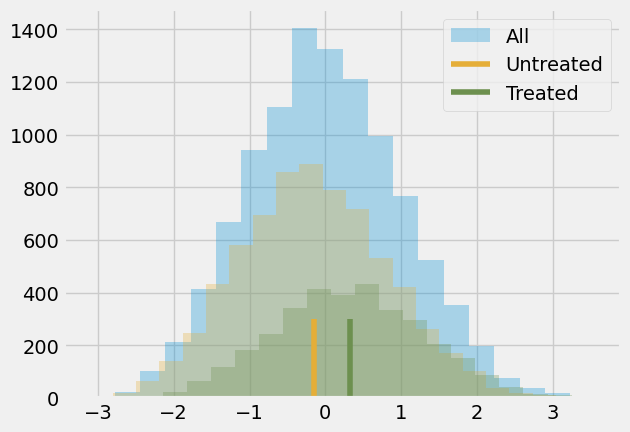

In [5]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

물론 결과는 편향되어 있습니다. 편향이 양수이므로 `treated`와 `untreated`간 차이는 이보다는 작을 것입니다. 적극적인 학생들은 세미나에 참석하는 경향이 있어 이 학생들은 세미나에 참석하지 않았더라도 더 많은 것을 성취할 수 있습니다. 편향을 통제하기 위해 `regression`이나 `matching`을 사용할 수 있지만 여기서는 새로운 기술을 배워보겠습니다.

## Propensity Score

성향점수는 조건부 독립성 $(Y_1, Y_0) \perp T | X$를 얻기 위해 `confounder` $X$를 직접 제어할 필요가 없다는 인식에서 나왔습니다. 대신 `balancing score`(균형점수) $E[T|X]$만 제어하면 충분합니다. 균형점수는 주로 `treatment`의 조건부 확률 $P(T|X)$로 주어지며 `propensity score`(성향점수) $P(x)$라고도 합니다. 성향점수를 사용하면 (매칭에서 했던 것처럼) `treatment`에 대한 `potential outcome`의 독립성을 얻기 위해 $X$ 전체를 조건으로 설정할 필요가 없습니다. 대신 아래와 같이 성향점수만 조건으로 하면 충분합니다.

$
(Y_1, Y_0) \perp T | P(x)
$

이에 대한 엄격한 증명이 있지만, 여기서는 직관적인 방법으로 이해해 보겠습니다. 성향점수는 `treatment`를 받을 조건부 확률입니다. 이는 $X$를 $T$로 변환하는 일종의 함수라 할 수 있습니다. 성향점수는 `variable` $X$와 `treatment` $T$ 사이의 중간 지점을 만듭니다. 인과 그래프는 아래와 같습니다.

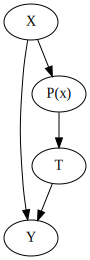

In [6]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "P(x)")
g.edge("P(x)", "T")
g

$P(x)$를 알고 있다면 $X$ 만으로는 $T$에 대해 더는 얻을 정보가 없습니다. 따라서 $P(x)$를 통제하는 것은 $X$를 통제하는 것과 같습니다. 앞의 예시로 돌아갑시다. 처음에는 `treated`와 `untreated`를 비교할 수 없습니다. 적극적인 학생은 사람들은 처치를 받거나(세미나 참석) 더 많은 것을 성취하는 경향이 크기 때문입니다. 하지만 `treatment`를 받을 가능성이 같은 두 사람을 각각 실험군과 대조군에서 뽑는다면 이들을 비교할 수 있습니다. `treatment`를 받을 확률이 정확히 같다면 `treatment`를 받거나 받지 않을 유일한 이유는 순전히 우연이기 때문입니다. 성향점수를 일정하게 유지하는 것은 데이터를 무작위만큼 좋게 만듭니다.

이제 직관을 얻었으니 수학적 증명을 살펴보도록 합시다. 우리는 $(Y_1, Y_0) \perp T | P(x)$가 아래와 같음을 보이고자 합니다.

$
E[T|P(x), X] = E[T|P(x)] 
$

수식은 $P(x)$를 조건으로 할 때 $X$는 $T$에 대한 추가 정보를 줄 수 없음을 의미합니다. 증명은 꽤 이상한데요. 방정식을 조금 바꿔 참임을 보일 것입니다. 먼저 왼쪽 $E[T|P(x), X]$를 살펴봅니다.

$
E[T|P(x), X] = E[T|X] = P(x)
$

$P(x)$는 $X$의 함수일 뿐이므로 $X$ 자체를 조건화한 후에는 더 이상의 정보를 제공하지 않습니다. 그런 다음 성향 점수 $E[T|X]$의 정의를 사용합니다.

오른쪽 항은 `Law of iterated expectations` $E[A] = E[E[A|B]$를 사용합니다. 이 법칙에 따르면 $A$의 기대값은 $A$를 $B$로 분할하고 평균하여 얻을 수 있습니다.

$
E[T|P(x)] = E[E[T|P(x),X]|P(x)] = E[P(x)|P(x)] = P(x)
$

첫 번째 항등식은 `law of iterated expectations`에 의한 것입니다. 두 번째 항등식은 왼쪽에서 알아낸 것에 의한 것입니다. 왼쪽과 오른쪽 모두 $P(x)$이므로 이 방정식은 참입니다.

## Propensity Weighting

![img](./data/img/ps/balance.png)

이제 성향점수를 얻었습니다. 다음은 뭐죠? 우리가 해야 할 일은 조건화입니다. 예를 들어 모든 $X$ 대신 성향 점수만을 조건으로 하는 선형 회귀 분석을 수행할 수 있습니다. 지금은 성향 점수만 사용하고 다른 것은 사용하지 않는 기술을 살펴보겠습니다. 이 아이디어는 성향점수로 조건부 차이의 평균을 기록합니다.

$
E[Y|X,T=1]−E[Y|X,T=0] = E\bigg[\dfrac{Y}{P(x)}|X,T=1\bigg]P(x) - E\bigg[\dfrac{Y}{(1-P(x))}|X,T=0\bigg](1-P(x))
$

더 단순하게 할 수 있지만, 성향점수가 무엇을 하고 있는지에 대한 좋은 직관을 제공하므로 이대로 보겠습니다. 첫 번째 항은 $Y_1$을 추정합니다. 처치된 데이터에 대해 `treatment`를 받을 확률로 `scaling` 합니다. 이는 `treatment`를 받을 가능성이 낮은 사람들에 높은 가중치를 줍니다. `treatment`를 받을 가능성이 낮은 사람이지만 `treated`입니다. 재미있겠네요. 우리는 `untreated` 처럼 보이지만 `treated`인 데이터에 높은 가중치를 부여할 것입니다. 이렇게 하면 원래 크기와 같지만 `treated` 만으로 이루어진 모집단이 만들어집니다. 같은 이유로 `untreated`로 보이지만 `treated` 처럼 보이는 데이터에 높은 가중치를 부여합니다. 이 방법은 각 `unit`를 다른 `treatment`를 받은 확률로 `scaling`하기 때문에 `IPTW`(Inverse Probability of Treatment Weighting)라고 합니다.

아래 그림은 가중치를 시각적으로 보여줍니다.

![img](./data/img/ps/iptw.png)

왼쪽 그림은 원본 데이터를 나타냅니다. 파란색 점은 `untreated`, 빨간색 점은 `treated`입니다. 아래 그림은 성향점수 $P(x)$입니다. $0$과 $1$ 사이 값으로 $X$에 따라 증가합니다. 오른쪽 그림은 가중치를 적용한 후의 데이터입니다. $X$가 작을수록 빨간색(`treated`) 데이터의 가중치는 커집니다. 마찬가지로 $X$가 클수록 파란색 데이터의 가중치가 큽니다.

이제 위 수식을 아래와 같이 단순하게 바꿀 수 있습니다.

$
E\bigg[Y \dfrac{T-P(x)}{P(x)(1-P(x))}\bigg|X\bigg]
$

$X$에 대해 적분하면 성향점수 가중치 추정기가 됩니다.

$
E\bigg[Y \dfrac{T-P(x)}{P(x)(1-P(x))}\bigg]
$

이 추정기를 사용하려면 $P(x)$ 와 $1-P(x)$가 0보다 커야 합니다. 모든 사람이 최소한의 `treatment`를 받을 기회와 받지 않을 기회를 가져야 함을 의미합니다. 이를 설명하는 또 다른 방법은 `treated` 분포와 `untreated` 분포가 겹쳐야 한다는 것입니다. 이는 인과추론의 **positivity assumption**라 합니다. 직관적으로 이해하자면 `treated`와 `untreated`가 겹치지 않은 상태는 데이터가 매우 다르다는 것을 의미하므로 한 그룹이 다른 그룹에 미치는 영향을 추정할 수 없게 됩니다. 외삽이 불가능한 것은 아니지만, 매우 위험합니다. 마치 남성에 잘 듣는 약이 여성에게도 똑같이 좋을 것이라 가정하는 것과 같습니다.

## Propensity Score Estimation

이상적으로는 참된 성향점수 $P(x)$를 얻을 수 있습니다. 하지만 실제로는 `treatment`를 할당하는 메커니즘은 알기 어려우며 성향점수를 추정치 $\hat{P}(x)$로 대체해야 합니다. 일반적인 방법은 로지스틱 회귀를 사용하는 것이지만 머신러닝을 사용할 수도 있습니다. (대신 과적합을 피하는 방법이 필요합니다.)

여기서는 로지스틱 회귀를 사용합니다. 데이터 세트의 범주형 변수를 더미 변수로 변환합니다.

In [7]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


이제 로지스틱 회귀로 성향점수를 추정합니다.

In [8]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315533
1,1,-0.449646,0.263687
2,1,0.769703,0.344069
3,1,-0.121763,0.344069
4,1,1.526147,0.367849


먼저 성향점수 가중치가 실제로 `treated` 만으로 된 모집단을 재구성하는지 확인합니다. 가중치 $1/P(x)$로 모든 사람이 `treatment`를 받는 모집단을 만들고 가중치 $1/(1-P(x))$로 모든 사람이 `treatment`를 받지 않는 모집단을 만듭니다.

In [9]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10387.999794643642
Untreated Population Sample Size 10391.775443020533


또한, 성향점수로 `confounding`의 증거를 찾을 수 있습니다. 모집단을 분리할 때 한 모집단이 다른 모집단보다 높은 성향점수를 갖는다면 무작위가 아닌 무언가가 `treatment`에 영향을 줌을 의미합니다. 같은 요인이 `outcome`에 영향을 준다면 `confounding`에 해당합니다. 여기서는 성공을 기대하는(`success_expect`) 학생들이 성장 사고방식 세미나에 참석할 확률이 높다는 사실을 알 수 있습니다.

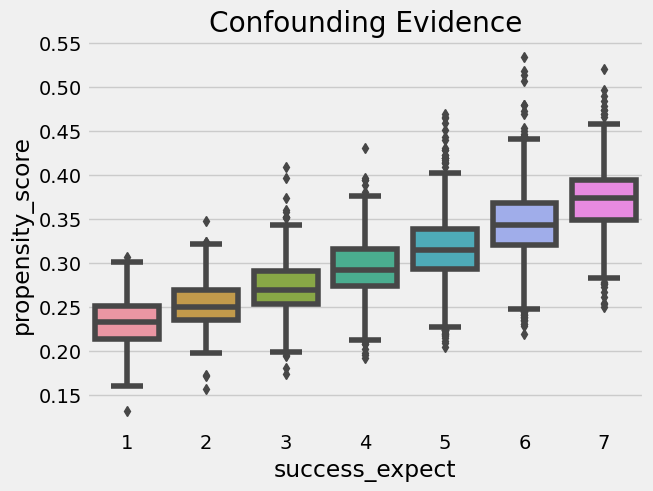

In [10]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

`treated`와 `untreated` 데이터 사이에 중복을 확인해야 합니다. 이를 위해 `treated`와 `untreated`의 성향점수 분포를 확인할 수 있습니다. 아래 결과에서 성향점수가 0인 사람은 없으며 성향점수가 낮거나 높은 영역에서 `treated`, `untreated` 모두 찾을 수 있습니다. 이러한 분포를 균형 잡혔다고 합니다(`nicely balanced`).

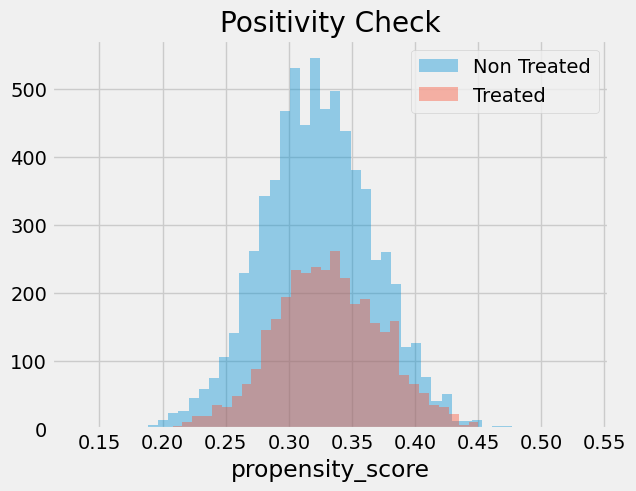

In [11]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

마지막으로 성향점수 가중치 추정기를 사용해 `ATE`를 추정합니다.

In [12]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", np.mean(weight * data_ps["achievement_score"]))

Y1: 0.25955383899505813
Y0: -0.12891714066174215
ATE 0.3884709796568001


성향점수 가중치는 `treated`가 `untreated` 보다 0.38 표준 편차만큼 높을 것으로 예상합니다. `treatment`를 받은 사람이 없다면 일반적인 성취도 수준은 현재보다 0.12 표준 편차가 낮을 것으로 예상합니다. 같은 이유로 모든 사람에게 세미나를 제공했다면 일반적인 성취 수준은 0.25 표준 편차가 더 높을 것입니다. 단순히 `T=0`, `T=1`로 분리하여 얻은 값인 0.47과 비교해 봅시다. 편향은 실제로 양수이며 $X$에 대한 통제는 성장 사고방식의 영향에 더 겸손한 추정치를 제공한다는 증거입니다.

## Standard Error

![img](./data/img/ps/bootstrap.png)

IPTW 추정기에 대한 표준 오차를 계산하기 위해 가중 평균의 분산 공식을 사용할 수 있습니다.

$
\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}
$

하지만 이를 계산하기 위해서는 이상적인 성향점수가 필요합니다. $\hat{P}(x)$를 추정하기 위해서 추정 과정의 오차를 알아야 합니다. 가장 쉬운 방법은 전체 절차를 `bootstrapping`(부트스트랩, 무작위 추출에 의존하는 실험)하는 것입니다. 원본 데이터에서 샘플링하고 ATE를 계산하여 수행합니다. 이 과정을 여러 번 반복하여 ATE 추정치의 분포를 얻습니다.

In [13]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

`ATE`는 부트스트랩 샘플의 평균이 됩니다. 신뢰 구간을 얻기 위해 부트스트랩 분포의 분위수를 검사할 수 있습니다. 95% C.I의 경우 2.5, 97.5 백분위수를 사용합니다.

In [14]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3877462297999537
95% C.I.: (0.35451340719137264, 0.41992762663472816)


또한, 신뢰 구간과 함께 부트스트랩 샘플이 어떻게 생겼는지 시각적으로 볼 수 있습니다.

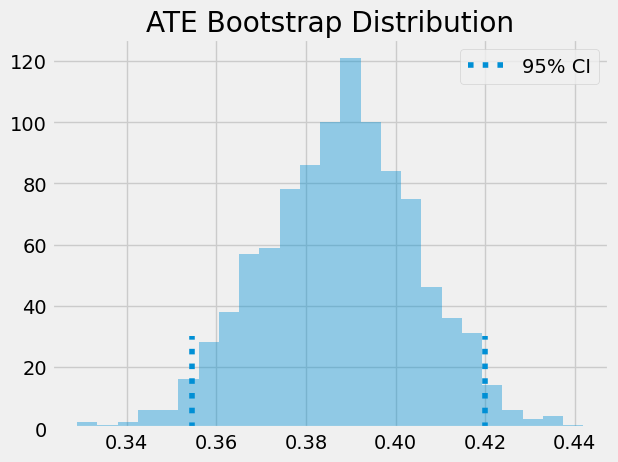

In [15]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

## Common Issues with Propensity Score

데이터 과학자로서 성향점수를 정확히 알기 위해 첨단 기계 학습의 유혹에 빠지기 쉽습니다. AUC 최적화, 교차 검증, 베이지안 하이퍼 파라미터 튜닝 등에 열중할 수 있습니다. 그러지 말라는 건 아닙니다. 사실 성향 점수와 기계 학습은 매우 최근의 것으로 아직 모르는 것이 많습니다. 하지만 이해가 먼저입니다.

성향점수의 예측값은 균형특성으로 변환되지 않습니다. 인과추론이 어려운 이유는 문제를 예측 문제로만 생각하면 안 되기 때문입니다. 성향점수의 예측 정확도를 높이는 것은 인과추론에 악영향을 주기도 합니다. **성향 점수는 treatment를 잘 예측할 필요가 없습니다. 모든 교란 변수가 포함되기만 하면 됩니다.** `treatment`를 예측하는 데 우수하지만, 결과에 영향을 주지 않는 변수를 포함한다면 성향 점수 추정기의 분산은 증가합니다. 7장에서 살펴본 `treatment`와는 상관관계가 있지만 `outcome`과는 관련이 없을 때 선형 회귀에서 보이는 문제와 유사합니다.

![img](./data/img/ps/ml-trap.png)

Hernán's Book의 예시를 살펴봅시다. 2개의 학교가 있으며 한 학교는 99%의 학생에게 성장 사고방식 세미나를 제공하고 다른 학교는 1% 학생에게만 제공합니다. 학교 자체는 `treatment effect`에 영향을 주지 않아 통제할 필요가 없다고 가정합니다. 하지만 학교를 성향점수 모델에 추가하면 예측력이 매우 높아집니다. 우연히 모든 샘플이 A 학교 학생이라면 성향점수가 1이 되고 무한한 분산을 가지게 됩니다. 극단적인 예이지만 시뮬레이션된 데이터에서 어떻게 보이는지 확인해보겠습니다.

In [16]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
ex_data = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))
ex_data.head()

,T,school,intercept,y
0,1,0,1,0.309526
1,1,0,1,1.571468
2,1,0,1,2.982024
3,1,0,1,2.445420
4,1,0,1,2.693187


데이터를 시뮬레이션하고 성향점수 알고리즘에 대해 부트스트랩을 두 번 실행합니다. 첫 번째는 학교를 성향점수 모델의 특징으로 포함합니다. 두 번째는 학교를 모델에 포함하지 않습니다.

In [17]:
ate_w_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

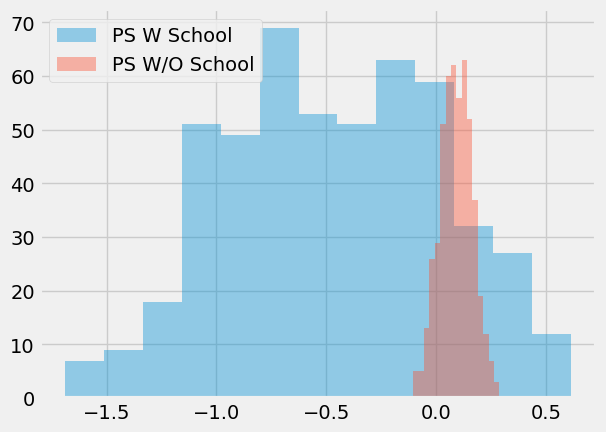

In [18]:
sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend();

학교 `feature`를 추가하는 성향점수 추정기는 엄청난 분산이 있지만 학교 `feature`가 없는 것은 훨씬 더 잘 작동합니다. 학교는 `confounder`가 아니므로 `feature`에 포함하지 않아도 모델이 편향되지 않습니다. 단순히 `treatment`를 예측하는 것은 `propensity score`의 목적이 아닙니다. `propensity score`는 `treatment`를 예측하는 것보다는 `confounding`을 통제하는 것에 초점을 맞춰야 합니다.

학교 `feature`를 사용하는 것은 성향점수 방법에서 자주 발생하는 또 다른 문제로 이어집니다. 앞의 사례에서는 데이터가 잘 균형 잡힌 것으로 나타났습니다. 하지만 항상 그런 것은 아닙니다. 경우에 따라 `treated` 그룹이 `untreated` 그룹보다 `treatment`를 가능성이 훨씬 높으며 성향점수 분포가 거의 겹치지 않습니다.

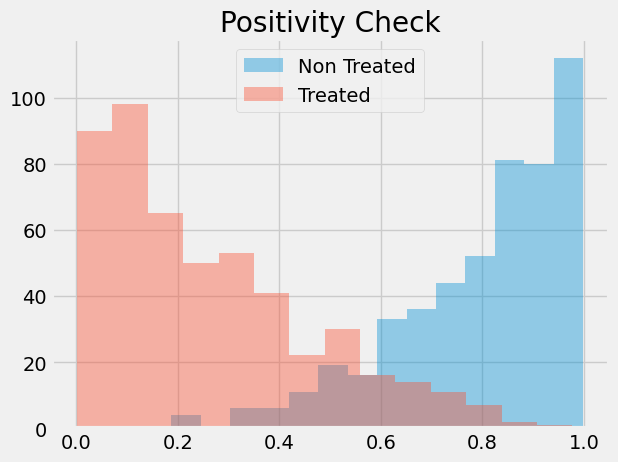

In [19]:
sns.distplot(np.random.beta(4,1,500), kde=False, label="Non Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

이는 `positivity`가 강하지 않다는 의미입니다. `treated`의 성향점수가 0.9이지만 `untreated`의 최대 성향점수가 0.7이라면 0.9 성향 점수를 받은 사람과 비교할 때 `untreated`에 해당하는 데이터가 없습니다. 균형의 부족은 알려지지 않은 영역에 대해 `treatment effect`를 외삽해야 하므로 편향을 만들 수 있습니다. 그뿐만 아니라 성향 점수가 매우 높거나 매우 낮은 `unit`은 가중치가 높아 분산이 증가합니다. 경험적으로 가중치가 20보다 크면 문제가 발생합니다. (성향 점수가 0.95인 처치를 받지 않거나 성향 점수가 0.05인 처치를 받은 경우)

최대 크기가 20이 되도록 가중치를 `clipping`할 수 있겠지만 `clipping`은 분산을 줄이는 대신 편향을 더 많이 만듭니다. `clipping`은 분산을 줄이기 위한 일반적인 방법이지만 저는 별로 좋아하지 않습니다. `clipping`에 의해 발생하는 편향이 얼마나 큰지 절대 알 수 없을 것입니다. 또한, 분포가 겹치지 않으면 데이터로부터 인과적 결론을 내리기에 충분하지 않을 수 있습니다. 직관적으로 이해하기 위해 성향점수와 `matching`을 결합하는 기술을 살펴보겠습니다.

## Propensity Score Matching

앞에서 말했듯이 성향점수가 있으면 $X$를 통제할 필요가 없습니다. 성향점수만으로 $X$를 충분히 통제할 수 있습니다. 성향점수는 `feature` 공간에 대해 일종의 차원 축소를 수행하는 것으로 생각할 수 있습니다. $X$의 모든 `feature`를 단일 `treatment` 차원으로 축소합니다. 이러한 이유로 성향 점수를 다른 모델의 입력으로 사용할 수 있습니다. 회귀 분석을 예로 들어 보겠습니다.

In [20]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0756,0.065,-47.057,0.000,-3.204,-2.947
intervention,0.3930,0.019,20.974,0.000,0.356,0.430
propensity_score,9.0504,0.200,45.309,0.000,8.659,9.442


성향점수를 `feature`로 사용하면 `ATE`는 0.39로 추정되는데 앞에서 성향점수를 통제하지 않은 결과인 0.47보다 낮습니다. 성향점수에 `matching`을 사용할 수도 있습니다. 모든 $X$에서 유사한 `feature`를 찾는 대신 성향점수가 같은 `unit`을 찾을 수 있습니다.

이 방법은 차원의 저주를 비껴갈 수 있으므로 큰 개선이라 할 수 있습니다. 성향점수 모델은 `treatment`와 관련이 없는 `feature`를 중요도를 낮게 지정합니다. 반면, `matching`은 중요하지 않은 `feature`에 대해 일치하는 데이터를 찾으려고 시도할 것입니다.

In [21]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.390      0.025     15.449      0.000      0.341      0.440
           ATC      0.380      0.028     13.652      0.000      0.326      0.435
           ATT      0.411      0.027     15.307      0.000      0.359      0.464



성향점수와 `matching`을 같이 사용한 경우 0.38의 `ATE`를 얻습니다. 이는 앞에서 성향점수 가중치로 본 것과 더 가깝습니다. 추가로 성향점수 매칭 `treated`와 `untreated` 사이에 겹치는 부분이 작은 것이 위험한 이유에 대한 통찰을 줍니다. 겹치는 부분이 작다면 성향점수에 대한 불일치가 커지므로 10장에서 확인한 것과 같은 방법으로 편향이 생깁니다.

마지막으로 주의할 점은 위의 표준 오차는 성향점수 추정의 불확실성을 설명하지 않아 잘못되었다는 것입니다. 유감스럽게도 [bootstrap은 matching과 함께 작동하지 않습니다](https://economics.mit.edu/files/11862). 성향점수 matching은 너무 최근의 것으로 정확한 표준 오차를 제공하는 라이브러리가 없습니다. 따라서 파이썬에서는 성향점수 매칭의 예시를 많이 찾아볼 수 없습니다.

## Key Ideas

11장에서는 `treatment`를 받을 확률을 성향점수로 정의하고 이를 균형점수로 사용하는 방법에 관해 공부했습니다. 성향 점수를 가지고 있다면 직접 `confounding`을 통제할 필요가 없습니다. 대신 성향점수를 통제하는 것으로 충분합니다. 또한, 성향점수가 $X$에 대한 차원 축소의 결과임을 배웠습니다.

성향점수 가중치 추정기를 도출했을 뿐만 아니라, 추정기로 교란변수 편향을 어떻게 제어할 수 있는지 살펴보았습니다.

그런 다음 성향점수를 사용할 때 발생할 수 있는 몇 가지 문제를 살펴보았습니다. 그 중 하나는 `treatment` 예측에 너무 열중하는 것입니다. `treatment`의 예측 성능만을 높이는 것은 분산을 증가시킬 수 있어 나쁜 인과결과를 도출할 수 있습니다.

마지막으로 `treated`와 `untreated` 사이에 성향점수 분포가 중첩이 없을 때 발생하는 몇 가지 외삽 문제를 공부했습니다.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

The data that we used was taken from the article [Estimating Treatment Effects with Causal Forests: An Application](https://arxiv.org/pdf/1902.07409.pdf), by Susan Athey and Stefan Wager. 

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).